In [178]:
import pandas as pd
pd.options.display.max_columns=None

import numpy as np

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pickle


import wandb
from wandb.keras import WandbCallback

wandb.init(project="my-test-project2", entity="padda")

In [3]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = (cm[0][0]+cm[1][1]+cm[2][2])/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

# Data load and transform

In [23]:
train_df = pd.read_csv("data/training_data/train_more_features.csv", index_col = 0)

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29545 entries, 0 to 29544
Columns: 213 entries, H_wins to Home_result
dtypes: float16(212), int64(1)
memory usage: 12.4 MB


In [25]:
train_df = train_df.drop(columns = ['game_id'])
train_df = train_df.astype(dtype={x:np.float16 for x in train_df.columns[:-1]})

In [27]:
#divise par 5 car c'est grosso modo le maximum que l'on puisse trouver aux différents postes (sauf GK)
col_select = [ 'H_attack', 'H_defense', 'H_midfield', 'A_attack', 'A_defense', 'A_midfield']
train_df.loc[:,col_select]=train_df.loc[:,col_select]/5

In [28]:
#divise par 5 car le maximum est 5 étoiles
col_select1 = ['skill_moves','international_reputation','weak_foot']
col_select1 = [x+y+z for x in ['H_','A_'] for y in ['GK_','ATK_','DEF_','MF_'] for z in col_select1]
train_df.loc[:,col_select1]=train_df.loc[:,col_select1]/5

In [35]:
#On divise les différentes notes des joueurs par 100 (note maximum)
col_select2 = col_select+col_select1+['H_GK','A_GK','Home_result']

col_mask = [x  for x in train_df.columns if (x not in col_select2)]
train_df.loc[:,col_mask]=train_df.loc[:,col_mask]/100



# Construction du df d'entrainement

In [37]:
#Remplace la différence de but par 0:HomeWin, 1: Draw, 2: AwayWin
train_df.Home_result=train_df.Home_result.apply(lambda x: np.int8(0) if x>0 else (np.int8(2) if x<0 else np.int8(1)))

In [38]:
X = train_df.loc[:,train_df.columns[:-1]]
y = train_df.Home_result

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=0, stratify=y)

In [41]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [42]:
train_batch = train.shuffle(len(y_train)).batch(20)
val_batch = test.shuffle(len(y_test)).batch(20)

# Fully Connected Neural Network + Dropout

In [43]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import *
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.models import Sequential

In [179]:
sequential_model = Sequential()
sequential_model.add(Dense(256,'relu', input_shape = [212]))
sequential_model.add(Dropout(.25))
sequential_model.add(Dense(128,'relu', kernel_regularizer=L1L2(l1=5e-5, l2=5e-4),bias_regularizer=L2(5e-4), activity_regularizer=L2(1e-4)))
sequential_model.add(Dropout(.25))
sequential_model.add(Dense(16,'relu', kernel_regularizer=L1L2(l1=5e-5, l2=5e-4),bias_regularizer=L2(5e-4), activity_regularizer=L2(1e-4)))
sequential_model.add(Dense(3,'softmax'))


In [180]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = Adam(0.0002)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
sequential_model.compile(optimizer=opt, loss=loss, metrics = [metric])

In [181]:
history = sequential_model.fit(train_batch, epochs=400, validation_data=val_batch, callbacks=[WandbCallback()])

Epoch 1/400
1108/1108 [==============================] - 5s 3ms/step - loss: 1.1745 - sparse_categorical_accuracy: 0.4644 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.5159
Epoch 2/400
1108/1108 [==============================] - 3s 3ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.5092 - val_loss: 1.0800 - val_sparse_categorical_accuracy: 0.5097
Epoch 3/400
1108/1108 [==============================] - 3s 2ms/step - loss: 1.0602 - sparse_categorical_accuracy: 0.5140 - val_loss: 1.0515 - val_sparse_categorical_accuracy: 0.5162
Epoch 4/400
1108/1108 [==============================] - 2s 2ms/step - loss: 1.0409 - sparse_categorical_accuracy: 0.5165 - val_loss: 1.0445 - val_sparse_categorical_accuracy: 0.5026
Epoch 5/400
1108/1108 [==============================] - 2s 2ms/step - loss: 1.0273 - sparse_categorical_accuracy: 0.5200 - val_loss: 1.0262 - val_sparse_categorical_accuracy: 0.5206
Epoch 6/400
1108/1108 [==============================] - 2s 2ms/step - loss: 1.0167 -

wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/padda/my-test-project2/277bafv6/file_stream (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x162195be0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
NoneType: None


In [162]:
y_pred = sequential_model.predict(X.values).argmax(axis=-1)
y_test_pred = sequential_model.predict(X_test.values).argmax(axis=-1)
y_train_pred = sequential_model.predict(X_train.values).argmax(axis=-1)

In [163]:
predicted_label = sorted(train_df.Home_result.unique())
sorted(train_df.Home_result.unique())

[0, 1, 2]

accuracy:  0.5291728712603222
Recall: 
 {0: 0.791503464899066, 1: 0.0033351862145636463, 2: 0.5623622741295725} 
Precision: 
 {0: 0.5528198653198653, 1: 0.25, 2: 0.4887016468785906} 
F1-score: 
 {0: 0.6509726180151159, 1: 0.006582556226001096, 2: 0.5229508196721312}


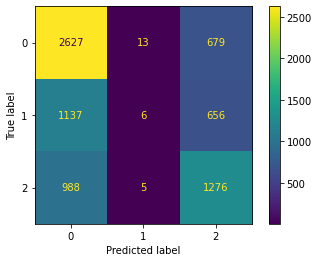

In [164]:
cm_metrics(y_test,y_test_pred, predicted_label)

accuracy:  0.553208773354996
Recall: 
 {0: 0.8273056057866185, 1: 0.004633061527057079, 2: 0.5872502937720329} 
Precision: 
 {0: 0.5665244909190974, 1: 0.4807692307692308, 2: 0.5281373844121532} 
F1-score: 
 {0: 0.6725193956717027, 1: 0.009177679882525696, 2: 0.5561274168869105}


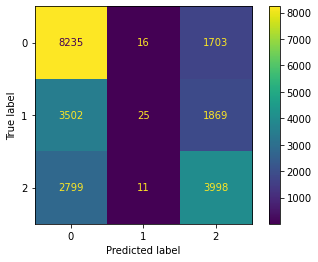

In [165]:
cm_metrics(y_train,y_train_pred, predicted_label)

# MLP Classifier

In [72]:
from sklearn.neural_network import MLPClassifier

In [139]:
MLPC = MLPClassifier((200,100),solver='lbfgs', alpha=10, learning_rate_init=0.001, max_iter=500)

In [140]:
MLPC.fit(X_train, y_train)

/Users/pierreadda/opt/anaconda3/envs/foot_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=10, hidden_layer_sizes=(200, 100), max_iter=500,
              solver='lbfgs')

In [141]:
y_train_pred = MLPC.predict(X_train)
y_test_pred = MLPC.predict(X_test)

accuracy:  0.5472064265727954
Recall: 
 {0: 0.8105284307815953, 1: 0.022053372868791696, 2: 0.5784371327849589} 
Precision: 
 {0: 0.565738727999439, 1: 0.40893470790378006, 2: 0.5177491454115172} 
F1-score: 
 {0: 0.6663638240759859, 1: 0.041849832952347454, 2: 0.5464132093797696}


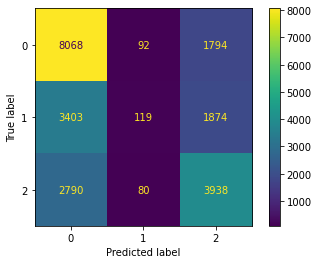

In [142]:
cm_metrics(y_train,y_train_pred,MLPC.classes_)

accuracy:  0.5363476377419791
Recall: 
 {0: 0.7921060560409762, 1: 0.021122846025569762, 2: 0.5707360070515646} 
Precision: 
 {0: 0.5621124652555056, 1: 0.3333333333333333, 2: 0.49884437596302} 
F1-score: 
 {0: 0.6575787893946973, 1: 0.03972817564035547, 2: 0.5323741007194244}


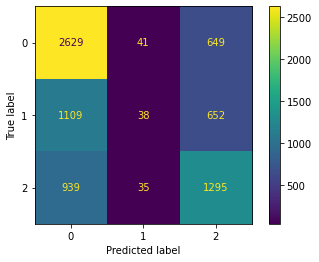

In [143]:
cm_metrics(y_test,y_test_pred,MLPC.classes_)

In [45]:
y.value_counts()

0    13273
2     9077
1     7195
Name: Home_result, dtype: int64

In [46]:
13273/(13273+9077+7195)

0.44924691149094603

In [56]:
MLPC

MLPClassifier(max_iter=500, solver='lbfgs')

In [59]:
pickle.dump(MLPC,open('../data/Model/mlp_classifier1.pkl','wb'))

In [60]:
y_pred = MLPC.predict(X)

accuracy:  0.5385005923168049
Recall: 
 {0: 0.7980863406916296, 1: 0.027102154273801252, 2: 0.5642833535309023} 
Precision: 
 {0: 0.5610996345145399, 1: 0.35583941605839414, 2: 0.506226526981617} 
F1-score: 
 {0: 0.6589325702911171, 1: 0.05036807438977141, 2: 0.533680646001563}


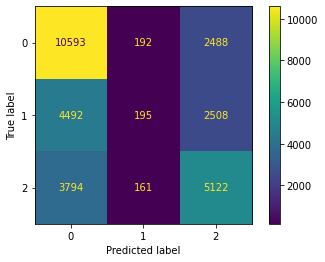

In [61]:
cm_metrics(y,y_pred,MLPC.classes_)

In [62]:
MLPC.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



MLPClassifier(max_iter=500, solver='lbfgs')

accuracy:  0.543205280081232
Recall: 
 {0: 0.8053944097039102, 1: 0.022376650451702573, 2: 0.5726561639308142} 
Precision: 
 {0: 0.5630761127205689, 1: 0.3770491803278688, 2: 0.5129774005723873} 
F1-score: 
 {0: 0.6627813255626512, 1: 0.04224612962477041, 2: 0.5411764705882354}


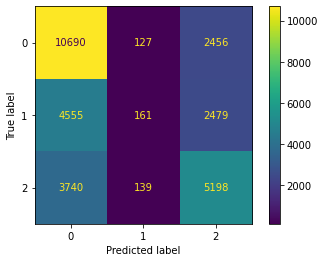

In [64]:
y_pred = MLPC.predict(X)
cm_metrics(y,y_pred,MLPC.classes_)

In [4]:
MLPC = pickle.load(open('../data/Model/mlp_classifier.pkl', 'rb'))

In [5]:
MLPC.predict_proba(X[y==2])[:20]

NameError: name 'X' is not defined

In [182]:
30000/64

468.75

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/padda/my-test-project2/277bafv6/file_stream (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x161bb8760>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
NoneType: None
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk HTTPSConnectionPool(host='api.wandb.ai', p